## Import libraries

In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', 50)
plt.rcParams['figure.figsize'] = [12,6]
sns.set_style('darkgrid')

## Import dataset

In [2]:
df = pd.read_csv('creditcard.csv')

Let's check the head and the summary of our data.

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

We have 31 columns. All are numerical variable. There is no missing values in any of our columns. There is nothing we can do with the "Time" column, so I'll just drop it.

In [5]:
df.drop('Time',axis=1,inplace=True)

## Exploratory data analysis
First, let's check the correlation of our data.

In [6]:
df.corr()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
V1,1.000000e+00,4.697350e-17,-1.424390e-15,1.755316e-17,6.391162e-17,2.398071e-16,1.991550e-15,-9.490675e-17,2.169581e-16,7.433820e-17,2.438580e-16,2.422086e-16,-2.115458e-16,9.352582e-16,-3.252451e-16,6.308789e-16,-5.011524e-16,2.870125e-16,1.818128e-16,1.036959e-16,-1.755072e-16,7.477367e-17,9.808705e-16,7.354269e-17,-9.805358e-16,-8.621897e-17,3.208233e-17,9.820892e-16,-0.227709,-0.101347
V2,4.697350e-17,1.000000e+00,2.512175e-16,-1.126388e-16,-2.039868e-16,5.024680e-16,3.966486e-16,-4.413984e-17,-5.728718e-17,-4.782388e-16,9.468995e-16,-6.588252e-16,3.854521e-16,-2.541036e-16,2.831060e-16,4.934097e-17,-9.883008e-16,2.636654e-16,9.528280e-17,-9.309954e-16,8.444409e-17,2.500830e-16,1.059562e-16,-8.142354e-18,-4.261894e-17,2.601622e-16,-4.478472e-16,-3.676415e-16,-0.531409,0.091289
V3,-1.424390e-15,2.512175e-16,1.000000e+00,-3.416910e-16,-1.436514e-15,1.431581e-15,2.168574e-15,3.433113e-16,-4.233770e-16,6.289267e-16,-5.501758e-17,2.206522e-16,-6.883375e-16,4.271336e-16,1.122756e-16,1.183364e-15,4.576619e-17,5.427965e-16,2.576773e-16,-9.429297e-16,-2.971969e-17,4.648259e-16,2.115206e-17,-9.351637e-17,4.771164e-16,6.521501e-16,6.239832e-16,7.726948e-16,-0.210880,-0.192961
V4,1.755316e-17,-1.126388e-16,-3.416910e-16,1.000000e+00,-1.940929e-15,-2.712659e-16,1.556330e-16,5.195643e-16,3.859585e-16,6.055490e-16,-2.083600e-16,-5.657963e-16,-1.506129e-16,-8.522435e-17,-1.507718e-16,-6.939204e-16,-4.397925e-16,1.493667e-16,-2.656938e-16,-3.223123e-16,-9.976950e-17,2.099922e-16,6.002528e-17,2.229738e-16,5.394585e-16,-6.179751e-16,-6.403423e-17,-5.863664e-17,0.098732,0.133447
V5,6.391162e-17,-2.039868e-16,-1.436514e-15,-1.940929e-15,1.000000e+00,7.926364e-16,-4.209851e-16,7.589187e-16,4.205206e-16,-6.601716e-16,7.342759e-16,3.761033e-16,-9.578659e-16,-3.634803e-16,-5.132620e-16,-3.517076e-16,1.425729e-16,1.109525e-15,-3.138234e-16,2.076048e-16,-1.368701e-16,5.060029e-16,1.637596e-16,-9.286095e-16,5.625102e-16,9.144690e-16,4.465960e-16,-3.299167e-16,-0.386356,-0.094974
V6,2.398071e-16,5.024680e-16,1.431581e-15,-2.712659e-16,7.926364e-16,1.000000e+00,1.429426e-16,-1.707421e-16,1.114447e-16,2.850776e-16,4.865799e-16,2.140589e-16,-2.268061e-16,3.452801e-16,-6.368111e-18,-2.477917e-16,3.567582e-16,2.811474e-16,2.717167e-16,1.898638e-16,-1.575903e-16,-3.362902e-16,-7.232186e-17,-1.261867e-15,1.081933e-15,-2.378414e-16,-2.623818e-16,4.813155e-16,0.215981,-0.043643
V7,1.991550e-15,3.966486e-16,2.168574e-15,1.556330e-16,-4.209851e-16,1.429426e-16,1.000000e+00,-8.691834e-17,7.933251e-16,3.043333e-17,-1.084105e-15,1.510045e-15,-9.892325e-17,-1.729462e-16,1.936832e-17,2.893672e-16,1.149692e-15,-1.116789e-16,-2.874017e-16,1.744242e-16,1.938604e-16,-1.058131e-15,2.327911e-16,-2.589727e-17,1.174169e-15,-7.334507e-16,-5.886825e-16,-6.836764e-17,0.397311,-0.187257
V8,-9.490675e-17,-4.413984e-17,3.433113e-16,5.195643e-16,7.589187e-16,-1.707421e-16,-8.691834e-17,1.000000e+00,2.900829e-16,9.051847e-17,1.954747e-16,-6.266057e-17,-2.382948e-16,-1.131098e-16,2.021491e-16,5.027192e-16,-3.508777e-16,-4.093852e-16,-5.339821e-16,-1.095534e-16,-2.412439e-16,5.475559e-16,3.897104e-16,-1.802967e-16,-1.390791e-16,-1.209975e-16,1.733633e-16,-4.484325e-16,-0.103079,0.019875
V9,2.169581e-16,-5.728718e-17,-4.233770e-16,3.859585e-16,4.205206e-16,1.114447e-16,7.933251e-16,2.900829e-16,1.000000e+00,-2.771761e-16,4.682341e-16,-2.445230e-15,-2.650351e-16,2.343317e-16,-1.588105e-15,-3.251906e-16,6.535992e-16,1.203843e-16,1.120752e-16,-4.340941e-16,4.578389e-17,2.871855e-17,5.929286e-16,-2.346385e-16,1.099645e-15,-1.388725e-15,-2.287414e-16,9.146779e-16,-0.044246,-0.097733
V10,7.433820e-17,-4.782388e-16,6.289267e-16,6.055490e-16,-6.601716e-16,2.850776e-16,3.043333e-17,9.051847e-17,-2.771761e-16,1.000000e+00,2.624448e-16,1.439907e-15,-8.853582e-16,2.622513e-16,7.615272e-16,-1.705923e-15,3.674182e-15,3.986710e-16,2.663038e-17,-1.141888e-15,8.089504e-16,-6.707598e-16

It is hard to interpret the correlation just by looking at the dataframe. We have too many features. Instead, we can visualize the correlation using heatmap.

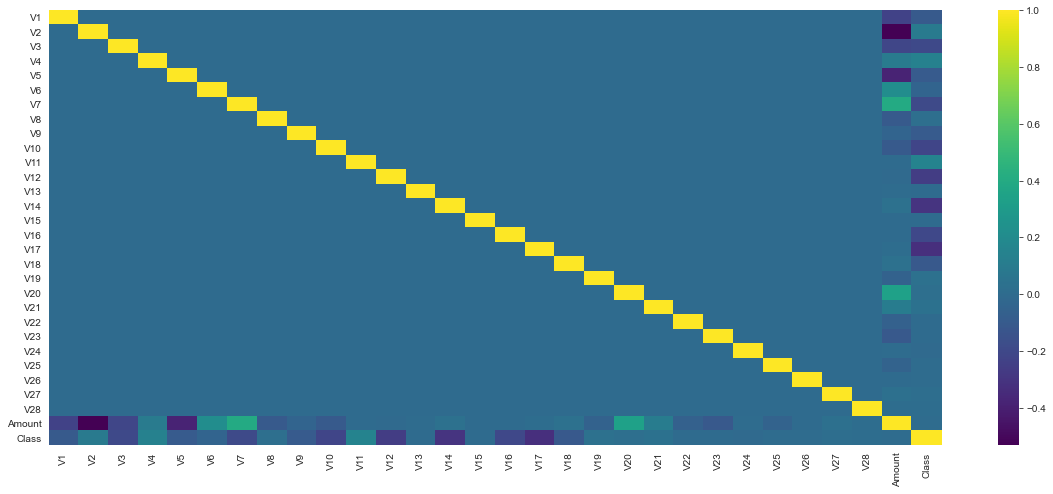

In [7]:
plt.figure(figsize=(20,8))
sns.heatmap(df.corr(),cmap='viridis')

All columns have little to no correlation, except for the "Amount" columns. It has a bit higher correlation with other columns, especially to V2. This might cause multicollinearity. Let's just keep it for now.

In [8]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

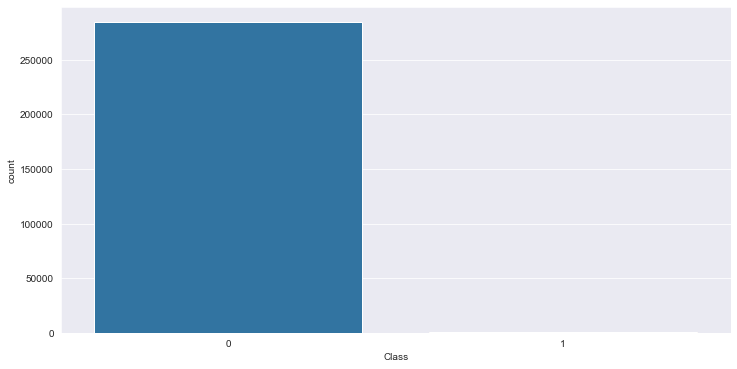

In [9]:
sns.countplot(df['Class'])

Here, we can clearly see that this is an imbalanced dataset. We have like 0.0017% fraud transactions.

# Building a Logistic Regression model
The objective of our model is to detect all fraud transactions.

## Splitting the dataset into training set and test set

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X = df.drop("Class",axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Training and predicting

In [12]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)

In [13]:
lr.fit(X_train,y_train)
prediction = lr.predict(X_test)

## Evaluation

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score

In [15]:
accuracy_score(y_test,prediction)

0.999204147794436

Looks great right? We created a model with 99% accuracy. But look at this.

In [16]:
print(confusion_matrix(y_test,prediction))
print('\n')
print(classification_report(y_test,prediction))

[[85284    12]
 [   56    91]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.88      0.62      0.73       147

    accuracy                           1.00     85443
   macro avg       0.94      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443



56 fraud transactions were classified as negative (false negative) and 12 non-fraud transactions were classified as positive (false positive). Remember our objective; to detect all fraud transactions. We have to minimize these false negative and false positive. Instead of using accuracy as our metric, we can use f1-score where it considers both precision and recall.

For this model, the f1-score is 73%. How can we impove our score? There are several ways. First, we can use other algorithms, such as decision tree or support vector machines. Second, we can do threshold-moving. Third, oversampling and undersampling.

## Building a Decision Tree model

In [17]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()

In [18]:
tree.fit(X_train,y_train)
prediction = tree.predict(X_test)

In [19]:
print(confusion_matrix(y_test,prediction))
print('\n')
print(classification_report(y_test,prediction))

[[85253    43]
 [   27   120]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.74      0.82      0.77       147

    accuracy                           1.00     85443
   macro avg       0.87      0.91      0.89     85443
weighted avg       1.00      1.00      1.00     85443



The f1-score for our decision tree model is 77%, which is a bit higher compared to logistic regression model.

## Threshold-moving
Instead of using default threshold, which is 0.5, we can can use other values. Threshold-moving is used to find the most optimal threshold.

In [20]:
from sklearn.metrics import precision_recall_curve

In [21]:
prob = lr.predict_proba(X_test)

In [22]:
precision, recall, threshold = precision_recall_curve(y_test,prob[:,1])

Text(0, 0.5, 'Recall')

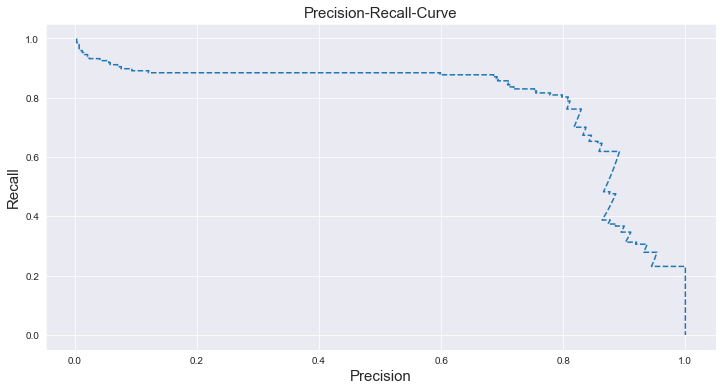

In [23]:
plt.plot(precision,recall, '--')
plt.title('Precision-Recall-Curve', fontsize=15)
plt.xlabel('Precision', fontsize=15)
plt.ylabel('Recall', fontsize=15)

In [24]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)

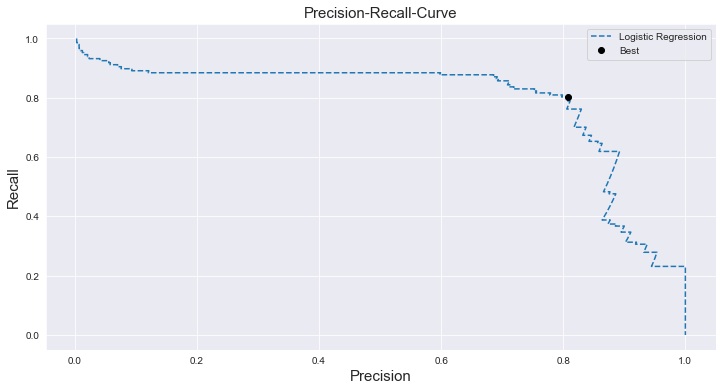

In [25]:
plt.plot(precision,recall, '--', label='Logistic Regression')
plt.plot(precision[ix], recall[ix], 'o', color='black', label='Best')
plt.title('Precision-Recall-Curve', fontsize=15)
plt.xlabel('Precision', fontsize=15)
plt.ylabel('Recall', fontsize=15)
plt.legend()

In [26]:
print('Threshold: {}'.format(threshold[ix]))
print('F1-Score: {}'.format(fscore[ix]))

Threshold: 0.08291037055493596
F1-Score: 0.8054607508532423


The most optimal threshold we can use is 0.083 where the f1-score is 81%.

## Oversampling and undersampling
Oversampling is a technique where we select random instances from the minority class and adding them to the training set. Meanwhile, undersampling is a technique where we downsize the majority class by removing instances until our data is balanced. The not-so-good part about these two techniques is for oversampling, it can cause overfitting since we will be using the same data points and for undersampling, it can cause loss of information since we will be removing a lot of data points.

Here, I will just show the oversampling part.

In [27]:
from imblearn.over_sampling import SMOTE

In [28]:
smote = SMOTE()

In [29]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [30]:
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [31]:
prediction = lr.predict(X_test)

In [32]:
print(confusion_matrix(y_test,prediction))
print('\n')
print(classification_report(y_test,prediction))

[[83799  1497]
 [   13   134]]


              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85296
           1       0.08      0.91      0.15       147

    accuracy                           0.98     85443
   macro avg       0.54      0.95      0.57     85443
weighted avg       1.00      0.98      0.99     85443



Our f1-score is only 15%. Our model classified most of the negative class as fraud.